# Exploring Neighbourhoods of Toronto

## Introduction
Toronto is the capital city of the province of Ontario in Canada. It is also the largest city in both Ontario and Canada. Found It is on the north-west side of Lake Ontario. The City of Toronto has a population of over 3 million people. Even more people live in the regions around it. All together, the Greater Toronto Area is home to over 6 million people. That makes it the biggest metropolitan area in Canada. 

## Problem Description
<p>A person has got a lucrative job offer in Toronto and has to shift with his family to Toronto.
As he is currently residing in India, he is very comfortable with the neighbourhood and  venues in India.However as he cannot reject the job offer, he wants to explore the neighbourhoods of Toronto,the venues in the neighbourhood like popular eating joints,theatres and so on.
He wants to explore those neighbourhoods which match well with his current neighbourhood.</p>

I will segment it into different neighborhoods using the geographical coordinates of the center of each neighborhood, and then using a combination of location data and machine learning, I will group the neighborhoods into clusters. 

## Target audience:
I believe this is for every person who is shifting from one place to another. As the need for a job everyone must travel and wants to be in a place where he got all the amenities. After a long hour of job, he needs that the daily needs should be nearer as much it can be. So, predicting the Battle of neighborhood is correct for description for this project. 

##  Dataset:
I would be using the Canada data to explore the neighborhood. The link for the wikipedia is 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'






In [42]:
#Installing the packages
#get_ipython().system(u' pip install --upgrade pip')
#get_ipython().system(u' pip install beautifulsoup4')
#!pip install lxml
#!pip install html5lib
#!pip install requests

#Importing packages
from bs4 import BeautifulSoup
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation

#!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize
# import k-means from clustering stage
from sklearn.cluster import KMeans
#!conda install -c conda-forge folium=0.5.0 --yes
import folium # plotting library
import matplotlib.cm as cm
import matplotlib.colors as colors
print('Folium installed')
print('Libraries imported.')

Folium installed
Libraries imported.


### Reading HTML page and getting rows and columns

In [2]:
#Reading HTMl page 
url='https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
response=requests.get(url)
html = response.text
page = BeautifulSoup(html,'html.parser')
#print(page)


#Getting table from the page that is saved in page1
wiki_table = page.body.table.tbody
#print(wiki_table)

# table = page.find_all('table')[0] # Grab the first table

# definition for getting cell
def get_cell(element):
    cells = element.find_all('td')
    row = []
    
    for cell in cells:
        if cell.a:            
            if (cell.a.text):
                row.append(cell.a.text)
                continue
        row.append(cell.string.strip())
        
    return row
#Definition for getting rows.
def get_row():    
    data = []  
    
    for tr in wiki_table.find_all('tr'):
        row = get_cell(tr)
        if len(row) != 3:
            continue
        data.append(row)        
    
    return data

#### Creating a Dataframe for 3 columns PostalCode, Borough, and Neighborhood

In [3]:
rows = get_row()
columns_get = ['Postcode', 'Borough', 'Neighbourhood']
df = pd.DataFrame(rows, columns=columns_get)
df.head()

,Postcode,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


#### Shape of the dataframe before dropping

In [4]:
df.shape

(180, 3)

#### Cleaning the data

In [5]:
df=df[df.Borough != 'Not assigned']
df = df.sort_values(by=['Postcode','Borough'])

df.reset_index(inplace=True)
df.drop('index',axis=1,inplace=True)

df.head()

,Postcode,Borough,Neighbourhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


#### Dropping the duplicates

In [6]:
df_post = df['Postcode']
df_post.drop_duplicates(inplace=True)
#df_post
df_new = pd.DataFrame(df_post)
df_new['Borough'] = '';
df_new['Neighbourhood'] = '';

In [7]:
df_new.reset_index(inplace=True)
df_new.drop('index', axis=1, inplace=True)
df.reset_index(inplace=True)
df.drop('index', axis=1, inplace=True)

#### Using groupby function to group the same Postcode and Borough in neighbourhood.

In [8]:
df_postcode = df.groupby(['Postcode', 'Borough'])['Neighbourhood'].apply(', '.join).reset_index()
df_postcode.head()


,Postcode,Borough,Neighbourhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


#### Getting new Dataframe shape after cleaning

In [9]:
df_postcode.shape


(103, 3)

#### DataFrame displayed with latitude and longitude.<br>Reading from a csv file which has all the coordinates of each postal code.
 

In [10]:
locgeo_df = pd.read_csv('https://cocl.us/Geospatial_data', index_col='Postal Code')
toronto_data = df_postcode.join(locgeo_df, on='Postcode')
toronto_data.drop('Postcode', axis=1, inplace=True)

print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(toronto_data['Borough'].unique()),
        toronto_data.shape[0]
    )
)
print(toronto_data.shape)
toronto_data.head()

The dataframe has 10 boroughs and 103 neighborhoods.
(103, 4)


,Borough,Neighbourhood,Latitude,Longitude
0,Scarborough,"Malvern, Rouge",43.806686,-79.194353
1,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497
2,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,Scarborough,Woburn,43.770992,-79.216917
4,Scarborough,Cedarbrae,43.773136,-79.239476


#### To generate maps to visualize our Neighbourhoods 

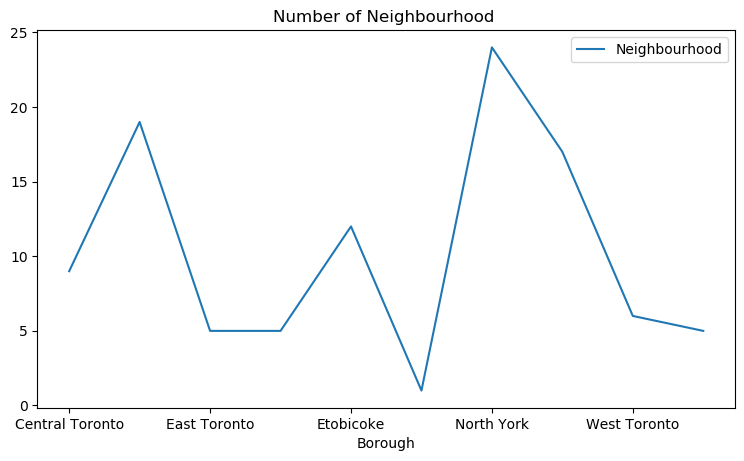

In [11]:
import matplotlib.pyplot as plt
plt.figure(figsize=(9,5), dpi = 100)
plt.title('Number of Neighbourhood ')
#On x-axis
#plt.xlabel('Borough', fontsize = 15)
#On y-axis
#plt.ylabel('No.of Neighbourhood', fontsize=15)
#giving a line plot
toronto_data.groupby('Borough')['Neighbourhood'].count().plot(kind='line')
#legend
plt.legend()
#displays the plot
plt.show()

# Define Foursquare Credentials and Version


In [12]:
CLIENT_ID = 'ZOGYZYX4FJBVRUACLNGHYT1VAMOPMM4UEEMNN3DMXNX1CUEF' # your Foursquare ID
CLIENT_SECRET = 'GO4VKJZVNWY3ZHEL4AVRNWMPV4AQMRKV3WIRGVMPQOULXLAU' # your Foursquare Secret
VERSION = '20180605'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: ZOGYZYX4FJBVRUACLNGHYT1VAMOPMM4UEEMNN3DMXNX1CUEF
CLIENT_SECRET:GO4VKJZVNWY3ZHEL4AVRNWMPV4AQMRKV3WIRGVMPQOULXLAU


## Explore Neighbourhoods of Toronto
#### Use geopy library to get the latitude and longitude values of Toronto.

In [13]:
address = '123 Queen St W, Toronto, CA'

geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6511085, -79.38347444469197.


#### Create a mapof Toronto with Neighbourhoods superimposed on top

In [14]:
# create map of Canada using latitude and longitude values
map_canada = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(toronto_data['Latitude'], toronto_data['Longitude'], toronto_data['Borough'], toronto_data['Neighbourhood']):
    label = '{}, {}'.format(neighborhood, borough)
    
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_canada)  
    
map_canada

In [15]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [17]:
Toronto_venues = getNearbyVenues(names=toronto_data['Neighbourhood'],
                                   latitudes=toronto_data['Latitude'],
                                   longitudes=toronto_data['Longitude']
                                  )
Toronto_venues.head()


Malvern, Rouge
Rouge Hill, Port Union, Highland Creek
Guildwood, Morningside, West Hill
Woburn
Cedarbrae
Scarborough Village
Kennedy Park, Ionview, East Birchmount Park
Golden Mile, Clairlea, Oakridge
Cliffside, Cliffcrest, Scarborough Village West
Birch Cliff, Cliffside West
Dorset Park, Wexford Heights, Scarborough Town Centre
Wexford, Maryvale
Agincourt
Clarks Corners, Tam O'Shanter, Sullivan
Milliken, Agincourt North, Steeles East, L'Amoreaux East
Steeles West, L'Amoreaux West
Upper Rouge
Hillcrest Village
Fairview, Henry Farm, Oriole
Bayview Village
York Mills, Silver Hills
Willowdale, Newtonbrook
Willowdale, Willowdale East
York Mills West
Willowdale, Willowdale West
Parkwoods
Don Mills
Don Mills
Bathurst Manor, Wilson Heights, Downsview North
Northwood Park, York University
Downsview
Downsview
Downsview
Downsview
Victoria Village
Parkview Hill, Woodbine Gardens
Woodbine Heights
The Beaches
Leaside
Thorncliffe Park
East Toronto, Broadview North (Old East York)
The Danforth West, 

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Malvern, Rouge",43.806686,-79.194353,Wendy’s,43.807448,-79.199056,Fast Food Restaurant
1,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,Royal Canadian Legion,43.782533,-79.163085,Bar
2,"Guildwood, Morningside, West Hill",43.763573,-79.188711,RBC Royal Bank,43.766790,-79.191151,Bank
3,"Guildwood, Morningside, West Hill",43.763573,-79.188711,G & G Electronics,43.765309,-79.191537,Electronics Store
4,"Guildwood, Morningside, West Hill",43.763573,-79.188711,Big Bite Burrito,43.766299,-79.190720,Mexican Restaurant


In [18]:
#print(Toronto_venues.shape)
Toronto_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Malvern, Rouge",43.806686,-79.194353,Wendy’s,43.807448,-79.199056,Fast Food Restaurant
1,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,Royal Canadian Legion,43.782533,-79.163085,Bar
2,"Guildwood, Morningside, West Hill",43.763573,-79.188711,RBC Royal Bank,43.766790,-79.191151,Bank
3,"Guildwood, Morningside, West Hill",43.763573,-79.188711,G & G Electronics,43.765309,-79.191537,Electronics Store
4,"Guildwood, Morningside, West Hill",43.763573,-79.188711,Big Bite Burrito,43.766299,-79.190720,Mexican Restaurant


In [19]:
Toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Agincourt,5,5,5,5,5,5
"Alderwood, Long Branch",9,9,9,9,9,9
"Bathurst Manor, Wilson Heights, Downsview North",20,20,20,20,20,20
Bayview Village,4,4,4,4,4,4
"Bedford Park, Lawrence Manor East",23,23,23,23,23,23
...,...,...,...,...,...,...
"Willowdale, Willowdale West",5,5,5,5,5,5
Woburn,5,5,5,5,5,5
Woodbine Heights,7,7,7,7,7,7


In [20]:
print('There are {} uniques categories.'.format(len(Toronto_venues['Venue Category'].unique())))

There are 234 uniques categories.


## 3. Analyze Each Neighborhood


In [21]:
# one hot encoding
Toronto_onehot = pd.get_dummies(Toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Toronto_onehot['Neighborhood'] = Toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [Toronto_onehot.columns[-1]] + list(Toronto_onehot.columns[:-1])
Toronto_onehot = Toronto_onehot[fixed_columns]

Toronto_onehot.head()

,Yoga Studio,Accessories Store,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,...,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
Toronto_onehot.shape

(1332, 234)

## Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [23]:
Toronto_grouped = Toronto_onehot.groupby('Neighborhood').mean().reset_index()
Toronto_grouped

,Neighborhood,Yoga Studio,Accessories Store,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store
0,Agincourt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"Alderwood, Long Branch",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,"Bathurst Manor, Wilson Heights, Downsview North",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Bayview Village,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,"Bedford Park, Lawrence Manor East",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.043478,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,"Willowdale, Willowdale West",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
92,Woburn,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
93,Woodbine Heights,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
94,York Mills West,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Let's print each neighborhood along with the top 5 most common venues

In [24]:
num_top_venues = 5

for hood in Toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = Toronto_grouped[Toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Agincourt----
                       venue  freq
0                     Lounge   0.2
1             Breakfast Spot   0.2
2  Latin American Restaurant   0.2
3             Clothing Store   0.2
4               Skating Rink   0.2


----Alderwood, Long Branch----
          venue  freq
0   Pizza Place  0.22
1          Pool  0.11
2   Coffee Shop  0.11
3           Pub  0.11
4  Skating Rink  0.11


----Bathurst Manor, Wilson Heights, Downsview North----
           venue  freq
0    Coffee Shop  0.10
1           Bank  0.10
2  Grocery Store  0.05
3  Deli / Bodega  0.05
4  Shopping Mall  0.05


----Bayview Village----
                 venue  freq
0                 Café  0.25
1   Chinese Restaurant  0.25
2  Japanese Restaurant  0.25
3                 Bank  0.25
4                Motel  0.00


----Bedford Park, Lawrence Manor East----
                venue  freq
0         Coffee Shop  0.09
1      Sandwich Place  0.09
2  Italian Restaurant  0.09
3          Restaurant  0.09
4           Juice Bar  0.04

              venue  freq
0    Baseball Field   1.0
1       Yoga Studio   0.0
2      Liquor Store   0.0
3  Malay Restaurant   0.0
4            Market   0.0


----Parkdale, Roncesvalles----
                         venue  freq
0                    Gift Shop  0.14
1               Breakfast Spot  0.14
2                 Dessert Shop  0.07
3                   Restaurant  0.07
4  Eastern European Restaurant  0.07


----Parkview Hill, Woodbine Gardens----
                  venue  freq
0           Pizza Place   0.2
1  Fast Food Restaurant   0.1
2             Gastropub   0.1
3             Pet Store   0.1
4                  Bank   0.1


----Parkwoods----
               venue  freq
0               Park   0.5
1  Food & Drink Shop   0.5
2        Yoga Studio   0.0
3  Mobile Phone Shop   0.0
4   Malay Restaurant   0.0


----Queen's Park, Ontario Provincial Government----
                venue  freq
0         Coffee Shop  0.20
1    Sushi Restaurant  0.07
2         Yoga Studio  0.03
3  Mexican Restaura

## Let's put that into a pandas dataframe

In [25]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [27]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = Toronto_grouped['Neighborhood']

for ind in np.arange(Toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Latin American Restaurant,Lounge,Clothing Store,Breakfast Spot,Skating Rink,Deli / Bodega,Drugstore,Donut Shop,Dog Run,Distribution Center
1,"Alderwood, Long Branch",Pizza Place,Coffee Shop,Pool,Sandwich Place,Skating Rink,Pharmacy,Gym,Pub,Curling Ice,Dance Studio
2,"Bathurst Manor, Wilson Heights, Downsview North",Coffee Shop,Bank,Gas Station,Middle Eastern Restaurant,Shopping Mall,Bridal Shop,Sandwich Place,Deli / Bodega,Ice Cream Shop,Restaurant
3,Bayview Village,Japanese Restaurant,Chinese Restaurant,Bank,Café,Women's Store,Deli / Bodega,Eastern European Restaurant,Drugstore,Donut Shop,Dog Run
4,"Bedford Park, Lawrence Manor East",Restaurant,Coffee Shop,Sandwich Place,Italian Restaurant,Pharmacy,Café,Pub,Sushi Restaurant,Cupcake Shop,Indian Restaurant


## 4. Cluster Neighborhoods
 Run k-means to cluster the neighborhood into 5 clusters.

In [46]:
# set number of clusters
kclusters = 5

Toronto_grouped_clustering = Toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [52]:
# add clustering labels
#neighborhoods_venues_sorted.insert(0, 'Cluster Labels1', kmeans.labels_)
neighborhoods_venues_sorted.head()

Toronto_merged = toronto_data

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
Toronto_merged = Toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighbourhood')

Toronto_merged.head() # check the last columns!

,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels1,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Scarborough,"Malvern, Rouge",43.806686,-79.194353,4.0,4.0,Fast Food Restaurant,Women's Store,Curling Ice,Drugstore,Donut Shop,Dog Run,Distribution Center,Discount Store,Diner,Dim Sum Restaurant
1,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,1.0,1.0,Bar,Women's Store,Dance Studio,Eastern European Restaurant,Drugstore,Donut Shop,Dog Run,Distribution Center,Discount Store,Diner
2,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,1.0,1.0,Electronics Store,Intersection,Rental Car Location,Medical Center,Bank,Moving Target,Breakfast Spot,Mexican Restaurant,Diner,Discount Store
3,Scarborough,Woburn,43.770992,-79.216917,1.0,1.0,Coffee Shop,Korean Restaurant,Soccer Field,Pharmacy,College Rec Center,Dance Studio,Drugstore,Donut Shop,Dog Run,Distribution Center
4,Scarborough,Cedarbrae,43.773136,-79.239476,1.0,1.0,Bakery,Bank,Athletics & Sports,Gas Station,Hakka Restaurant,Thai Restaurant,Caribbean Restaurant,Fried Chicken Joint,Dessert Shop,Deli / Bodega


Finally, let's visualize the resulting clusters

In [53]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
Toronto_merged["Cluster Labels"].replace(np.nan, 0, inplace=True)

for lat, lon, poi, cluster in zip(Toronto_merged['Latitude'], Toronto_merged['Longitude'], Toronto_merged['Neighbourhood'], Toronto_merged['Cluster Labels'].astype(int)):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## 5. Examine Clusters

Cluster 1

In [54]:
Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 0, Toronto_merged.columns[[1] + list(range(5, Toronto_merged.shape[1]))]]

,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
14,"Milliken, Agincourt North, Steeles East, L'Amo...",0.0,Coffee Shop,Park,Playground,Cupcake Shop,Donut Shop,Dog Run,Distribution Center,Discount Store,Diner,Dim Sum Restaurant
16,Upper Rouge,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21,"Willowdale, Newtonbrook",0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23,York Mills West,0.0,Park,Convenience Store,Women's Store,Dance Studio,Eastern European Restaurant,Drugstore,Donut Shop,Dog Run,Distribution Center,Discount Store
25,Parkwoods,0.0,Park,Food & Drink Shop,Women's Store,Curling Ice,Drugstore,Donut Shop,Dog Run,Distribution Center,Discount Store,Diner
40,"East Toronto, Broadview North (Old East York)",0.0,Park,Coffee Shop,Pizza Place,Convenience Store,Cupcake Shop,Donut Shop,Dog Run,Distribution Center,Discount Store,Diner
44,Lawrence Park,0.0,Park,Swim School,Bus Line,Electronics Store,Drugstore,Donut Shop,Dog Run,Distribution Center,Discount Store,Diner
48,"Moore Park, Summerhill East",0.0,Park,Summer Camp,Restaurant,Cupcake Shop,Donut Shop,Dog Run,Distribution Center,Discount Store,Diner,Dim Sum Restaurant
50,Rosedale,0.0,Park,Playground,Trail,Cuban Restaurant,Donut Shop,Dog Run,Distribution Center,Discount Store,Diner,Dim Sum Restaurant
74,Caledonia-Fairbanks,0.0,Park,Women's Store,Curling Ice,Eastern European Restaurant,Drugstore,Donut Shop,Dog Run,Distribution Center,Discount Store,Diner


Cluster 2

In [55]:
Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 1, Toronto_merged.columns[[1] + list(range(5, Toronto_merged.shape[1]))]]

,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,"Rouge Hill, Port Union, Highland Creek",1.0,Bar,Women's Store,Dance Studio,Eastern European Restaurant,Drugstore,Donut Shop,Dog Run,Distribution Center,Discount Store,Diner
2,"Guildwood, Morningside, West Hill",1.0,Electronics Store,Intersection,Rental Car Location,Medical Center,Bank,Moving Target,Breakfast Spot,Mexican Restaurant,Diner,Discount Store
3,Woburn,1.0,Coffee Shop,Korean Restaurant,Soccer Field,Pharmacy,College Rec Center,Dance Studio,Drugstore,Donut Shop,Dog Run,Distribution Center
4,Cedarbrae,1.0,Bakery,Bank,Athletics & Sports,Gas Station,Hakka Restaurant,Thai Restaurant,Caribbean Restaurant,Fried Chicken Joint,Dessert Shop,Deli / Bodega
5,Scarborough Village,1.0,Pizza Place,Playground,Women's Store,Cupcake Shop,Donut Shop,Dog Run,Distribution Center,Discount Store,Diner,Dim Sum Restaurant
...,...,...,...,...,...,...,...,...,...,...,...,...
96,Humber Summit,1.0,Pizza Place,Furniture / Home Store,Women's Store,Cupcake Shop,Drugstore,Donut Shop,Dog Run,Distribution Center,Discount Store,Diner
97,"Humberlea, Emery",1.0,Baseball Field,Food Service,Women's Store,Ethiopian Restaurant,Eastern European Restaurant,Drugstore,Donut Shop,Dog Run,Distribution Center,Discount Store
99,Westmount,1.0,Pizza Place,Coffee Shop,Middle Eastern Restaurant,Discount Store,Chinese Restaurant,Intersection,Sandwich Place,Dog Run,Distribution Center,Diner
101,"South Steeles, Silverstone, Humbergate, Jamest...",1.0,Grocery Store,Fried Chicken Joint,Pharmacy,Pizza Place,Sandwich Place,Beer Store,Fast Food Restaurant,Women's Store,Dance Studio,Deli / Bodega


Cluster 3

In [56]:
Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 2, Toronto_merged.columns[[1] + list(range(5, Toronto_merged.shape[1]))]]

,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
20,"York Mills, Silver Hills",2.0,Cafeteria,Women's Store,Curling Ice,Eastern European Restaurant,Drugstore,Donut Shop,Dog Run,Distribution Center,Discount Store,Diner


Cluster 4

In [57]:
Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 3, Toronto_merged.columns[[1] + list(range(5, Toronto_merged.shape[1]))]]

,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
94,"West Deane Park, Princess Gardens, Martin Grov...",3.0,Filipino Restaurant,Women's Store,Curling Ice,Drugstore,Donut Shop,Dog Run,Distribution Center,Discount Store,Diner,Dim Sum Restaurant


Cluster 5

In [59]:
Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 4, Toronto_merged.columns[[1] + list(range(5, Toronto_merged.shape[1]))]]

,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Malvern, Rouge",4.0,Fast Food Restaurant,Women's Store,Curling Ice,Drugstore,Donut Shop,Dog Run,Distribution Center,Discount Store,Diner,Dim Sum Restaurant
